In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect("database.sqlite")

tables = ['Country', 'League', 'Match', 'Player', 'Player_Attributes', 'Team', 'Team_Attributes']

df_country = pd.read_sql_query("SELECT * FROM Country", conn)
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

conn.close()

In [8]:
import pandas as pd

merged_df = pd.merge(df_team, df_match, left_on='team_api_id', right_on='home_team_api_id', how='inner')

final_df = pd.merge(merged_df, df_league, left_on='league_id', right_on='id', how='inner')

df_team_league_country = final_df[['team_long_name', 'team_api_id', 'name', 'id_x', 'country_id_y']].drop_duplicates()

df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_id']

df_team_league_country = pd.merge(df_team_league_country, df_country, left_on='country_id', right_on='id', how='left')

df_team_league_country = df_team_league_country[['team_name', 'team_api_id', 'league_name', 'league_id', 'name', 'country_id']]
df_team_league_country.columns = ['team_name', 'team_api_id', 'league_name', 'league_id', 'country_name', 'country_id']

df_team_league_country = df_team_league_country.sort_values(['country_name', 'league_name', 'team_name'])

df_team_league_country.to_csv('team_league_country_with_ids.csv', index=False)
teams = pd.merge(df_team_attributes,df_team, on='team_fifa_api_id', how='inner')  # Inner join
teams = pd.merge(teams, df_team_league_country, 
                     left_on='team_api_id_x', 
                     right_on='team_api_id', 
                     how='left')

print(teams.shape)
teams = teams[teams['country_id'].isin([1729,4769,7809,10257,21518])]
print(teams.shape)

teams['date'] = pd.to_datetime(teams['date'])

def get_filter_year():
    year = pd.to_datetime('2014-01-01')
    return year

def aggregate_numeric(x):
    return x.mean()

def aggregate_categorical(x):
    return x.mode().iloc[0]

filter_year = get_filter_year()

filtered_players = teams[teams['date'] >= filter_year]

numeric_columns = filtered_players.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = filtered_players.select_dtypes(include=['object']).columns

columns_to_aggregate = [col for col in filtered_players.columns if col not in ['date', 'year']]

aggregated_players = filtered_players.groupby('team_fifa_api_id').agg({
    **{col: aggregate_numeric for col in numeric_columns if col in columns_to_aggregate},
    **{col: aggregate_categorical for col in categorical_columns if col in columns_to_aggregate}
})



teams = aggregated_players
teams.set_index('team_api_id_x', inplace=True)
print(f"Filtered and aggregated data for players from {filter_year} onwards:")
print(teams.head())
print(f"\nShape of the aggregated data: {aggregated_players.shape}")


has_nan = teams.isnull().values.any()
print(f"Does teams contain NaN values? {has_nan}")

nan_count = teams.isnull().sum()
print("NaN count in each column:")
print(nan_count)

(1473, 35)
(924, 35)
Filtered and aggregated data for players from 2014-01-01 00:00:00 onwards:
                id_x  team_fifa_api_id  buildUpPlaySpeed  \
team_api_id_x                                              
9825.0          75.5               1.0              59.0   
10252.0         81.5               2.0              64.5   
8655.0         177.5               3.0              52.0   
8559.0         202.5               4.0              57.0   
8455.0         311.5               5.0              67.0   

               buildUpPlayDribbling  buildUpPlayPassing  \
team_api_id_x                                             
9825.0                         51.0                28.0   
10252.0                        34.5                63.0   
8655.0                         45.5                63.5   
8559.0                         35.5                67.0   
8455.0                         46.5                37.0   

               chanceCreationPassing  chanceCreationCrossing  \
team_

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_match_filtered = df_match[df_match['date'] > '2014-01-01']

df_combined = df_match_filtered.merge(df_league, left_on='league_id', right_on='id', suffixes=('', '_league'))
df_combined = df_combined.merge(df_country, left_on='country_id', right_on='id', suffixes=('', '_country'))

df_combined = df_combined.merge(df_team, left_on='home_team_api_id', right_on='team_api_id', suffixes=('', '_home_team'))
df_combined = df_combined.merge(df_team, left_on='away_team_api_id', right_on='team_api_id', suffixes=('', '_away_team'))

df_player_attributes['date'] = pd.to_datetime(df_player_attributes['date'])
df_combined['date'] = pd.to_datetime(df_combined['date'])

def get_team_avg_attributes(team_id, match_date):
    team_players = df_player_attributes[
        (df_player_attributes['date'] <= match_date) & 
        (df_player_attributes['player_api_id'].isin(df_combined[df_combined['home_team_api_id'] == team_id]['home_player_1'].unique()))
    ]
    team_players = team_players.sort_values('date').groupby('player_api_id').last()
    return team_players[['overall_rating', 'potential']].mean()

df_combined['home_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['home_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['home_team_api_id'], row['date'])['potential'], axis=1)
df_combined['away_team_avg_rating'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['overall_rating'], axis=1)
df_combined['away_team_avg_potential'] = df_combined.apply(lambda row: get_team_avg_attributes(row['away_team_api_id'], row['date'])['potential'], axis=1)

df_combined['match_outcome'] = df_combined.apply(lambda row: 1 if row['home_team_goal'] > row['away_team_goal'] else (0 if row['home_team_goal'] == row['away_team_goal'] else -1), axis=1)

attributes = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
              'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
              'defencePressure', 'defenceAggression', 'defenceTeamWidth',
              'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
              'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
              'chanceCreationPassingClass', 'chanceCreationCrossingClass',
              'chanceCreationShootingClass', 'chanceCreationPositioningClass',
              'defencePressureClass', 'defenceAggressionClass',
              'defenceTeamWidthClass', 'defenceDefenderLineClass']

for attr in attributes:
    df_combined[f'home_{attr}'] = df_combined['home_team_api_id'].map(teams[attr])
    df_combined[f'away_{attr}'] = df_combined['away_team_api_id'].map(teams[attr])

categorical_columns = ['buildUpPlaySpeedClass', 'buildUpPlayDribblingClass', 'buildUpPlayPassingClass',
                       'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass', 
                       'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass',
                       'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass']

def one_hot_encode_column(column):
    unique_values = column.unique()
    return column.apply(lambda x: list(unique_values).index(x))

for col in categorical_columns:
    df_combined[f'home_{col}'] = one_hot_encode_column(df_combined[f'home_{col}'])
    df_combined[f'away_{col}'] = one_hot_encode_column(df_combined[f'away_{col}'])
features_for_correlation = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential',
    'home_team_goal', 'away_team_goal', 'match_outcome'
]

for attr in attributes:
    features_for_correlation.append(f'home_{attr}')
    features_for_correlation.append(f'away_{attr}')

print(features_for_correlation)
df_combined.head()

['home_team_avg_rating', 'home_team_avg_potential', 'away_team_avg_rating', 'away_team_avg_potential', 'home_team_goal', 'away_team_goal', 'match_outcome', 'home_buildUpPlaySpeed', 'away_buildUpPlaySpeed', 'home_buildUpPlayDribbling', 'away_buildUpPlayDribbling', 'home_buildUpPlayPassing', 'away_buildUpPlayPassing', 'home_chanceCreationPassing', 'away_chanceCreationPassing', 'home_chanceCreationCrossing', 'away_chanceCreationCrossing', 'home_chanceCreationShooting', 'away_chanceCreationShooting', 'home_defencePressure', 'away_defencePressure', 'home_defenceAggression', 'away_defenceAggression', 'home_defenceTeamWidth', 'away_defenceTeamWidth', 'home_buildUpPlaySpeedClass', 'away_buildUpPlaySpeedClass', 'home_buildUpPlayDribblingClass', 'away_buildUpPlayDribblingClass', 'home_buildUpPlayPassingClass', 'away_buildUpPlayPassingClass', 'home_buildUpPlayPositioningClass', 'away_buildUpPlayPositioningClass', 'home_chanceCreationPassingClass', 'away_chanceCreationPassingClass', 'home_chanceCr

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,home_chanceCreationPositioningClass,away_chanceCreationPositioningClass,home_defencePressureClass,away_defencePressureClass,home_defenceAggressionClass,away_defenceAggressionClass,home_defenceTeamWidthClass,away_defenceTeamWidthClass,home_defenceDefenderLineClass,away_defenceDefenderLineClass
0,1237,1,1,2013/2014,1,2014-03-29,1677179,8475,9989,2,...,0,0,0,0,0,0,0,0,0,0
1,1238,1,1,2013/2014,1,2014-03-29,1677180,9991,8573,0,...,0,0,0,0,0,0,0,0,0,0
2,1239,1,1,2013/2014,2,2014-04-05,1677181,9989,9991,1,...,0,0,0,0,0,0,0,0,0,0
3,1240,1,1,2013/2014,2,2014-04-05,1677182,8573,8475,0,...,0,0,0,0,0,0,0,0,0,0
4,1241,1,1,2013/2014,3,2014-04-12,1677183,9991,8475,2,...,0,0,0,0,0,0,0,0,0,0


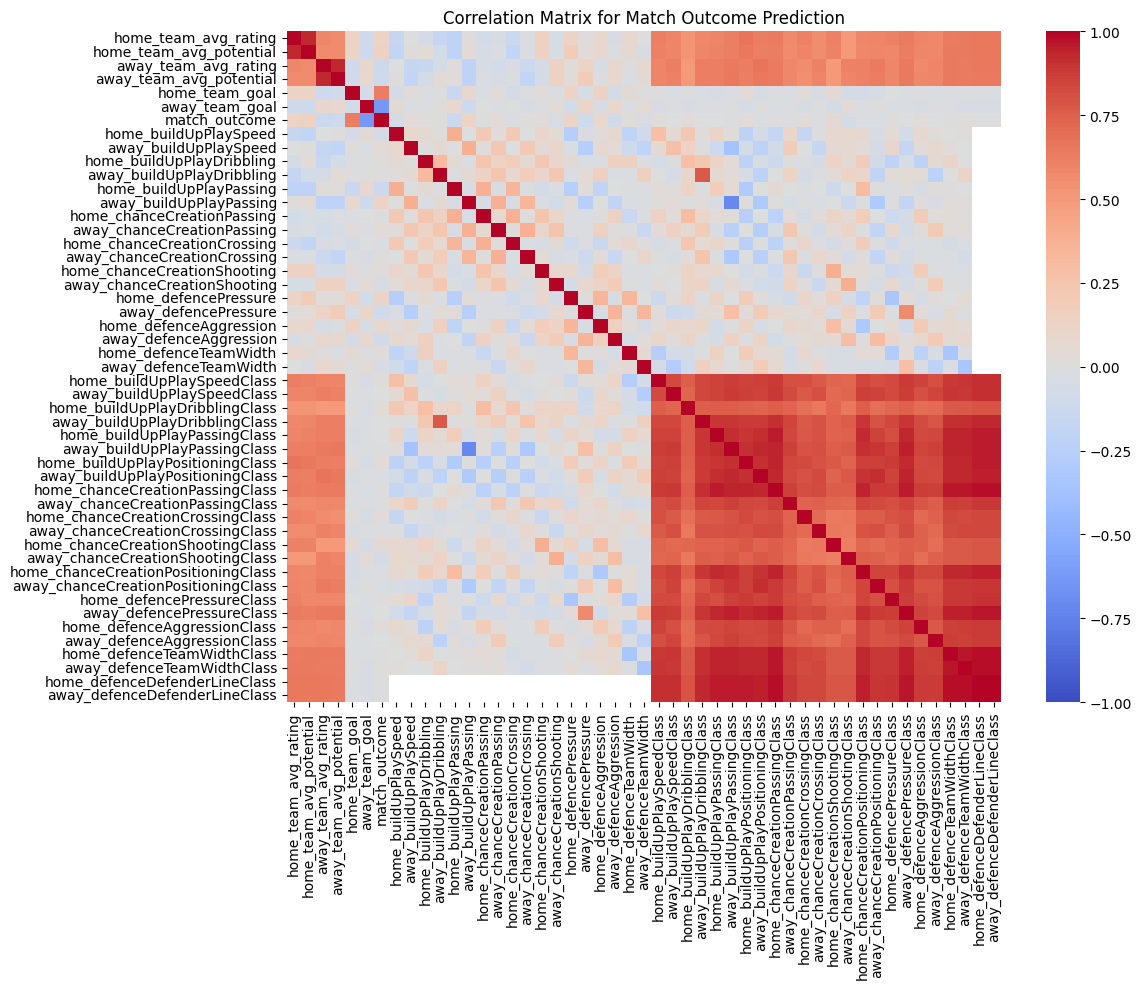

match_outcome                          1.000000
home_team_goal                         0.629581
home_team_avg_potential                0.136108
home_team_avg_rating                   0.129886
away_buildUpPlayPassing                0.118123
home_defencePressure                   0.110943
home_defenceAggression                 0.085196
home_chanceCreationShootingClass       0.062367
home_buildUpPlayPositioningClass       0.036009
away_chanceCreationPassing             0.033420
away_buildUpPlaySpeed                  0.032827
home_defenceAggressionClass            0.029318
home_chanceCreationShooting            0.027498
home_buildUpPlayDribblingClass         0.025178
home_chanceCreationCrossingClass       0.024686
home_buildUpPlaySpeedClass             0.022274
home_defenceTeamWidth                  0.015817
away_defenceTeamWidthClass             0.013028
home_buildUpPlayDribbling              0.012181
away_chanceCreationCrossing            0.012059
home_defencePressureClass              0

In [10]:

correlation_matrix = df_combined[features_for_correlation].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix for Match Outcome Prediction')
plt.tight_layout()
plt.show()

print(correlation_matrix['match_outcome'].sort_values(ascending=False))


In [11]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.neural_network import MLPClassifier


# features = [
#     'home_team_avg_rating', 'home_team_avg_potential',
#     'away_team_avg_rating', 'away_team_avg_potential'
# ]

# df_combined = df_combined.fillna(0)
# #print(df_combined.isnull().sum())

# X = df_combined[features]
# y = df_combined['match_outcome']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# models = {
#     'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
#     #'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
#     'Neural Network': MLPClassifier(hidden_layer_sizes=(500, 100), max_iter=500, random_state=42)
# }

# results = {}

# for name, model in models.items():
#     model.fit(X_train_scaled, y_train)
    
#     y_pred = model.predict(X_test_scaled)
    
#     accuracy = accuracy_score(y_test, y_pred)
    
#     results[name] = {
#         'accuracy': accuracy,
#         'confusion_matrix': confusion_matrix(y_test, y_pred),
#         'classification_report': classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win'], output_dict=True)
#     }
    
#     print(f"\n{name} Results:")
#     print(f"Accuracy: {accuracy:.4f}")
#     print("\nClassification Report:")
#     print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))
#     print("\nConfusion Matrix:")
#     print(confusion_matrix(y_test, y_pred))

# plt.figure(figsize=(10, 6))
# accuracies = [results[model]['accuracy'] for model in models]
# plt.bar(models.keys(), accuracies)
# plt.title('Model Accuracy Comparison')
# plt.ylabel('Accuracy')
# plt.ylim(0, 1)
# for i, v in enumerate(accuracies):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.show()

# class_names = ['Away Win', 'Draw', 'Home Win']

# fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# for i, (name, model) in enumerate(models.items()):
#     sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
#                 xticklabels=class_names, yticklabels=class_names)
#     axes[i].set_title(f'{name} Confusion Matrix')
#     axes[i].set_xlabel('Predicted')
#     axes[i].set_ylabel('Actual')
# plt.tight_layout()
# plt.show()

# f1_scores = {name: results[name]['classification_report']['weighted avg']['f1-score'] for name in models}
# plt.figure(figsize=(10, 6))
# plt.bar(f1_scores.keys(), f1_scores.values())
# plt.title('Weighted Average F1-Score Comparison')
# plt.ylabel('F1-Score')
# plt.ylim(0, 1)
# for i, v in enumerate(f1_scores.values()):
#     plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
# plt.show()

match_outcome
 1    2954
-1    1924
 0    1658
Name: count, dtype: int64


Epoch [10/500], Loss: 1.0223, Training Accuracy: 0.4904


Epoch [20/500], Loss: 1.0186, Training Accuracy: 0.4998


Epoch [30/500], Loss: 1.0215, Training Accuracy: 0.4966


Epoch [40/500], Loss: 1.0190, Training Accuracy: 0.4956


Epoch [50/500], Loss: 1.0147, Training Accuracy: 0.4979


Epoch [60/500], Loss: 1.0162, Training Accuracy: 0.4945


Epoch [70/500], Loss: 1.0145, Training Accuracy: 0.4977


Epoch [80/500], Loss: 1.0151, Training Accuracy: 0.5006


Epoch [90/500], Loss: 1.0166, Training Accuracy: 0.5000


Epoch [100/500], Loss: 1.0157, Training Accuracy: 0.4995


Epoch [110/500], Loss: 1.0104, Training Accuracy: 0.5023


Epoch [120/500], Loss: 1.0080, Training Accuracy: 0.5020


Epoch [130/500], Loss: 1.0102, Training Accuracy: 0.4974


Epoch [140/500], Loss: 1.0059, Training Accuracy: 0.5041


Epoch [150/500], Loss: 1.0121, Training Accuracy: 0.4998


Epoch [160/500], Loss: 1.0055, Training Accuracy: 0.5060


Epoch [170/500], Loss: 1.0045, Training Accuracy: 0.5057


Epoch [180/500], Loss: 1.0104, Training Accuracy: 0.5066


Epoch [190/500], Loss: 1.0042, Training Accuracy: 0.5043


Epoch [200/500], Loss: 1.0062, Training Accuracy: 0.5055


Epoch [210/500], Loss: 0.9979, Training Accuracy: 0.5107


Epoch [220/500], Loss: 1.0006, Training Accuracy: 0.5133


Epoch [230/500], Loss: 0.9955, Training Accuracy: 0.5138


Epoch [240/500], Loss: 0.9966, Training Accuracy: 0.5096


Epoch [250/500], Loss: 0.9986, Training Accuracy: 0.5155


Epoch [260/500], Loss: 0.9943, Training Accuracy: 0.5147


Epoch [270/500], Loss: 0.9953, Training Accuracy: 0.5135


Epoch [280/500], Loss: 0.9977, Training Accuracy: 0.5096


Epoch [290/500], Loss: 0.9995, Training Accuracy: 0.5155


Epoch [300/500], Loss: 0.9979, Training Accuracy: 0.5103


Epoch [310/500], Loss: 0.9907, Training Accuracy: 0.5167


Epoch [320/500], Loss: 0.9894, Training Accuracy: 0.5210


Epoch [330/500], Loss: 0.9919, Training Accuracy: 0.5150


Epoch [340/500], Loss: 0.9904, Training Accuracy: 0.5200


Epoch [350/500], Loss: 0.9935, Training Accuracy: 0.5155


Epoch [360/500], Loss: 0.9884, Training Accuracy: 0.5222


Epoch [370/500], Loss: 0.9865, Training Accuracy: 0.5168


Epoch [380/500], Loss: 0.9915, Training Accuracy: 0.5151


Epoch [390/500], Loss: 0.9866, Training Accuracy: 0.5207


Epoch [400/500], Loss: 0.9840, Training Accuracy: 0.5240


Epoch [410/500], Loss: 0.9833, Training Accuracy: 0.5225


Epoch [420/500], Loss: 0.9825, Training Accuracy: 0.5222


Epoch [430/500], Loss: 0.9828, Training Accuracy: 0.5225


Epoch [440/500], Loss: 0.9797, Training Accuracy: 0.5233


Epoch [450/500], Loss: 0.9817, Training Accuracy: 0.5228


Epoch [460/500], Loss: 0.9867, Training Accuracy: 0.5179


Epoch [470/500], Loss: 0.9840, Training Accuracy: 0.5243


Epoch [480/500], Loss: 0.9906, Training Accuracy: 0.5176


Epoch [490/500], Loss: 0.9856, Training Accuracy: 0.5242


Epoch [500/500], Loss: 0.9837, Training Accuracy: 0.5237
PyTorch Neural Network Accuracy on test set: 0.4914

Random Forest Results:
Accuracy: 0.4419

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.48      0.38      0.42       516
        Draw       0.23      0.17      0.20       405
    Home Win       0.50      0.64      0.56       713

    accuracy                           0.44      1634
   macro avg       0.40      0.40      0.39      1634
weighted avg       0.42      0.44      0.43      1634


Confusion Matrix:
[[197  92 227]
 [102  70 233]
 [113 145 455]]

PyTorch Neural Network Results:
Accuracy: 0.4914

Classification Report:
              precision    recall  f1-score   support

    Away Win       0.49      0.36      0.41       516
        Draw       0.00      0.00      0.00       405
    Home Win       0.49      0.87      0.63       713

    accuracy                           0.49      1634
   macro avg       0.33      0.41 

/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svrao3/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/svrao3/.local/li

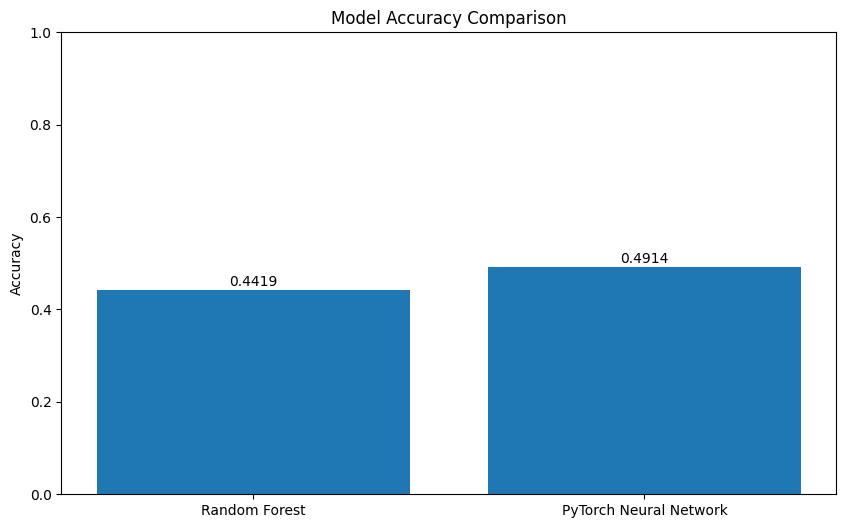

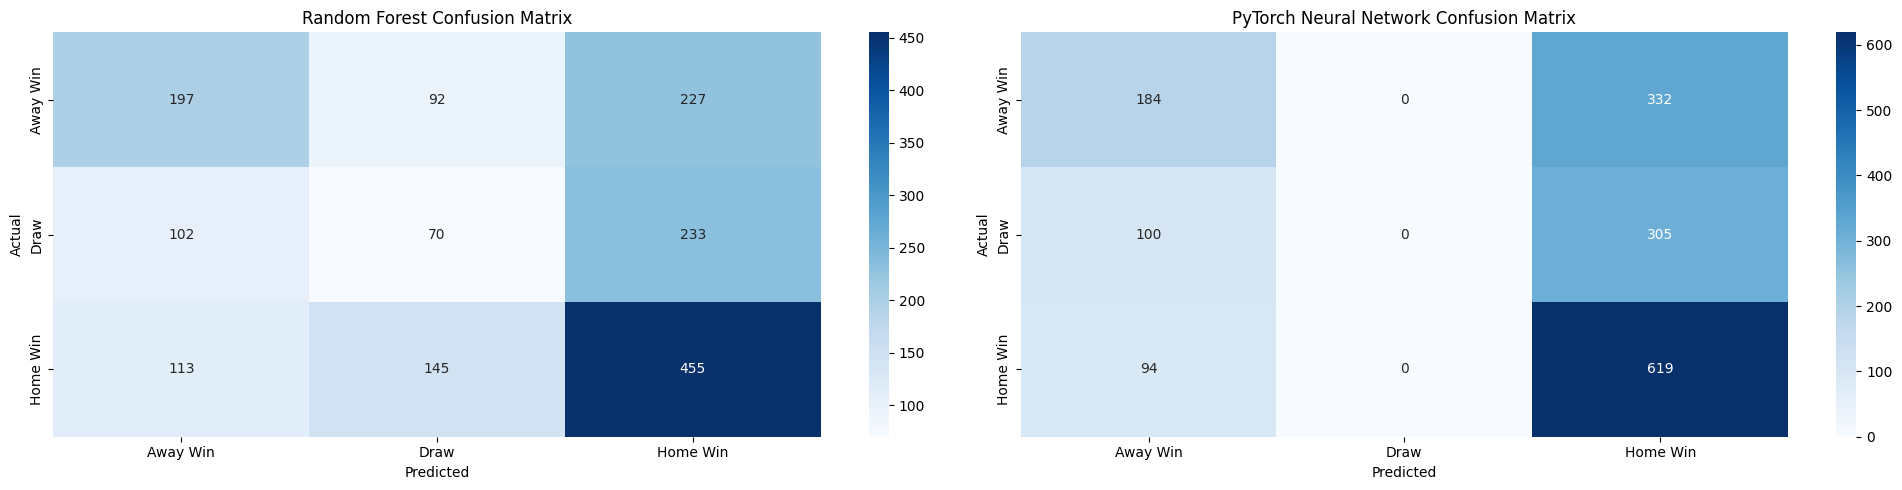

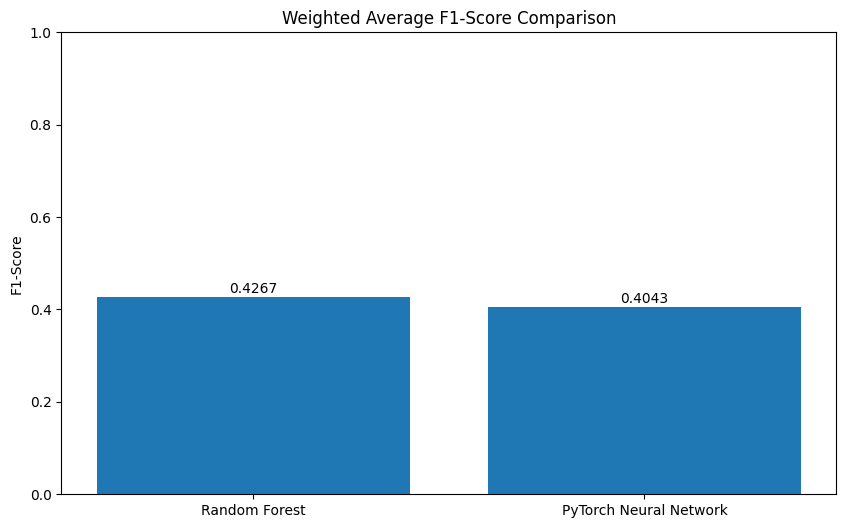

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def check(self, current_loss):
        if self.best_loss is None or (self.best_loss - current_loss) > self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False  # Continue training
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
            return False
        
# Neural network architecture (as defined previously)
class MatchOutcomeNN(nn.Module):
    def __init__(self, input_size):
        super(MatchOutcomeNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 3)  # Output for 3 classes
        self.dropout = nn.Dropout(0.4)  # Reduced dropout rate to 0.2

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.fc5(x)  # No softmax here since we'll use CrossEntropyLoss
        return x

def train_pytorch_nn(model, X_train, y_train, X_test, y_test, num_epochs=50, batch_size=32):
    y_train = y_train.replace({-1: 0, 1: 1, 0: 2})  # Replace labels for training data
    y_test = y_test.replace({-1: 0, 1: 1, 0: 2})  # Replace labels for test data
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)  # Convert to numpy array first
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)  # Convert to numpy array first
    
    # Create DataLoader for batching
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)  # Added L2 regularization
    scheduler = StepLR(optimizer, step_size=100, gamma=0.5)  # Reduce LR
    early_stopping = EarlyStopping(patience=20, min_delta=0.001)
    
    # Training loop with tqdm
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0  # Variable to count correct predictions during training
        total_samples = 0  # Variable to count total samples processed
        
        # Use tqdm to show a progress bar for batch processing
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Calculate number of correct predictions
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            
            running_loss += loss.item()
        scheduler.step()
        
        # Calculate training accuracy for every 10 epochs
        if (epoch+1) % 10 == 0:
            train_accuracy = correct_predictions / total_samples
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Training Accuracy: {train_accuracy:.4f}')
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        
        # Map the predicted labels back to original encoding
        predicted_mapped = predicted.numpy()
        predicted_mapped = np.where(predicted_mapped == 0, -1, predicted_mapped)  # 0 -> -1 (Loss)
        predicted_mapped = np.where(predicted_mapped == 2, 0, predicted_mapped)  # 2 -> 0 (Draw)
        predicted_mapped = np.where(predicted_mapped == 1, 1, predicted_mapped)  # 1 -> 1 (Win)
        
        # Calculate accuracy
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)
        print(f'PyTorch Neural Network Accuracy on test set: {accuracy:.4f}')
    
    return predicted_mapped, accuracy


# Prepare the data (assuming df_combined is already loaded and processed)
features = [
    'home_team_avg_rating', 'home_team_avg_potential',
    'away_team_avg_rating', 'away_team_avg_potential'
]
team_attr = ['buildUpPlaySpeed', 'buildUpPlayDribbling', 'buildUpPlayPassing', 
              'chanceCreationPassing', 'chanceCreationCrossing', 'chanceCreationShooting', 
              'defencePressure', 'defenceAggression', 'defenceTeamWidth',
              'buildUpPlaySpeedClass', 'buildUpPlayDribblingClass',
              'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
              'chanceCreationPassingClass', 'chanceCreationCrossingClass',
              'chanceCreationShootingClass', 'chanceCreationPositioningClass',
              'defencePressureClass', 'defenceAggressionClass',
              'defenceTeamWidthClass', 'defenceDefenderLineClass']
for attr in team_attr:
    features.append(f'home_{attr}')
    features.append(f'away_{attr}')

df_combined = df_combined.fillna(0)

X = df_combined[features]
y = df_combined['match_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
}

# Train the PyTorch Neural Network
input_size = X_train_scaled.shape[1]
nn_model = MatchOutcomeNN(input_size)
print(y_train.value_counts())
y_pred_nn, nn_accuracy = train_pytorch_nn(nn_model, X_train_scaled, y_train, X_test_scaled, y_test, num_epochs=500)

# Add the neural network results to the model dictionary
models['PyTorch Neural Network'] = nn_model

# Results dictionary
results = {}

# Evaluate all models
for name, model in models.items():
    if name == 'Random Forest':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
    else:
        y_pred = y_pred_nn  # Predictions from the PyTorch neural network
        accuracy = nn_accuracy

    results[name] = {
        'accuracy': accuracy,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win'], output_dict=True)
    }

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Away Win', 'Draw', 'Home Win']))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Plotting results
plt.figure(figsize=(10, 6))
accuracies = [results[model]['accuracy'] for model in models]
plt.bar(models.keys(), accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

# Confusion Matrices
class_names = ['Away Win', 'Draw', 'Home Win']
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for i, (name, model) in enumerate(models.items()):
    sns.heatmap(results[name]['confusion_matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=class_names, yticklabels=class_names)
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
plt.tight_layout()
plt.show()

# F1-Score Comparison
f1_scores = {name: results[name]['classification_report']['weighted avg']['f1-score'] for name in models}
plt.figure(figsize=(10, 6))
plt.bar(f1_scores.keys(), f1_scores.values())
plt.title('Weighted Average F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()
